# **Philadelphia Open Policing Project (OPP)**

​The Stanford Open Policing Project dataset comprises standardized records of traffic stops collected from various U.S. law enforcement agencies. In this case we focus on Philadelphia data. Each entry represents a single stop and includes fields such as date, time, location, driver demographics, reason for the stop, and outcome.

In [3]:
# Import Libraries

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import re
import folium
import geojson
from branca.colormap import linear, LinearColormap


# Set pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set visualization
plt.rcParams['figure.figsize'] = (20, 6)
plt.style.use('ggplot')


In [4]:
# Load the data

zip_path = "philadelphia_data.zip" # path for zip file

with zipfile.ZipFile(zip_path) as z: # CSV in zip file
    print(z.namelist())

    with z.open(z.namelist()[0]) as f: # read CSV file
        df = pd.read_csv(f)

df.head()

['pa_philadelphia_2020_04_01.csv']


C:\Users\acast\AppData\Local\Temp\ipykernel_15096\495672545.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,subject_sex,type,arrest_made,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle,raw_race,raw_individual_contraband,raw_vehicle_contraband
0,411981,2014-01-01,01:14:00,NaN,NaN,NaN,19.00,191,31.00,black,male,pedestrian,True,arrest,True,False,True,True,False,Black - Non-Latino,True,False
1,407442,2014-01-01,01:57:00,NaN,NaN,NaN,12.00,121,21.00,black,male,pedestrian,True,arrest,False,True,True,True,False,Black - Non-Latino,False,False
2,217556,2014-01-01,03:30:00,3400 BLOCK SPRUCE ST,39.95,-75.19,18.00,183,24.00,black,male,pedestrian,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False
3,217557,2014-01-01,03:40:00,3400 BLOCK SPRUCE ST,39.95,-75.19,18.00,183,20.00,black,male,pedestrian,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False
4,230988,2014-01-01,08:30:00,N 56TH ST / UPLAND WAY,39.98,-75.23,19.00,193,31.00,black,male,vehicular,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False


| Column name               | Column meaning                                                                                                                                                                                                                                                                                                                                                                                                   | Example value    |
|:--------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------|
| raw_row_number            | An number used to join clean data back to the raw data                                                                                                                                                                                                                                                                                                                                                           | 38299            |
| date                      | The date of the stop, in YYYY-MM-DD format. Some states do not provide the exact stop date: for example, they only provide the year or quarter in which the stop occurred. For these states, stop_date is set to the date at the beginning of the period: for example, January 1 if only year is provided.                                                                                                       | 2017-02-02       |
| time                      | The 24-hour time of the stop, in HH:MM format.                                                                                                                                                                                                                                                                                                                                                                   | 20:15            |
| location                  | The freeform text of the location. Occasionally, this represents the concatenation of several raw fields, i.e. street_number, street_name                                                                                                                                                                                                                                                                        | 248 Stockton Rd. |
| lat                       | The latitude of the stop. If not provided by the department, we attempt to geocode any provided address or location using Google Maps. Google Maps returns a "best effort" response, which may not be completely accurate if the provided location was malformed or underspecified. To protect against suprious responses, geocodes more than 4 standard deviations from the median stop lat/lng are set to NA.  | 72.23545         |
| lng                       | The longitude of the stop. If not provided by the department, we attempt to geocode any provided address or location using Google Maps. Google Maps returns a "best effort" response, which may not be completely accurate if the provided location was malformed or underspecified. To protect against suprious responses, geocodes more than 4 standard deviations from the median stop lat/lng are set to NA. | 115.2808         |
| district                  | Police district. If not provided, but we have retrieved police department shapefiles and the location of the stop, we geocode the stop and find the district using the shapefiles.                                                                                                                                                                                                                               | 8                |
| service_area              | Police service area. If not provided, but we have retrieved police department shapefiles and the location of the stop, we geocode the stop and find the service area using the shapefiles.                                                                                                                                                                                                                       | 8                |
| subject_age               | The age of the stopped subject. When date of birth is given, we calculate the age based on the stop date. Values outside the range of 10-110 are coerced to NA.                                                                                                                                                                                                                                                  | 54.23            |
| subject_race              | The race of the stopped subject. Values are standardized to white, black, hispanic, asian/pacific islander, and other/unknown                                                                                                                                                                                                                                                                                    | hispanic         |
| subject_sex               | The recorded sex of the stopped subject.                                                                                                                                                                                                                                                                                                                                                                         | female           |
| type                      | Type of stop: vehicular or pedestrian.                                                                                                                                                                                                                                                                                                                                                                           | vehicular        |
| arrest_made               | Indicates whether an arrest made.                                                                                                                                                                                                                                                                                                                                                                                | FALSE            |
| outcome                   | The strictest action taken among arrest, citation, warning, and summons.                                                                                                                                                                                                                                                                                                                                         | citation         |
| contraband_found          | Indicates whether contraband was found. When search_conducted is NA, this is coerced to NA under the assumption that contraband_found shouldn't be discovered when no search occurred and likely represents a data error.                                                                                                                                                                                        | FALSE            |
| frisk_performed           | Indicates whether a frisk was performed. This is technically different from a search, but departments will sometimes include frisks as a search type.                                                                                                                                                                                                                                                            | TRUE             |
| search_conducted          | Indicates whether any type of search was conducted, i.e. driver, passenger, vehicle. Frisks are excluded where the department has provided resolution on both.                                                                                                                                                                                                                                                   | TRUE             |
| search_person             | Indicates whether a search of a person has occurred. This is only defined when search_conducted is TRUE.                                                                                                                                                                                                                                                                                                         | TRUE             |
| search_vehicle            | Indicates whether a search of a vehicle has occurred. This is only defined when search_conducted is TRUE.                                                                                                                                                                                                                                                                                                        | TRUE             |
| raw_race                  | Raw racial data as received before standardization.                                                                                                                                                                                                                                                                                                                                                              | h                |
| raw_individual_contraband | Raw field related to contraband on the individual.                                                                                                                                                                                                                                                                                                                                                               | drug             |
| raw_vehicle_contraband    | Raw field related to contraband in the vehicle.    

In [6]:
df.shape

(1865096, 22)

We had more than 1.8M records.

In [8]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865096 entries, 0 to 1865095
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   raw_row_number             1865096 non-null  object 
 1   date                       1865096 non-null  object 
 2   time                       1865096 non-null  object 
 3   location                   1827596 non-null  object 
 4   lat                        1760399 non-null  float64
 5   lng                        1760399 non-null  float64
 6   district                   1865095 non-null  float64
 7   service_area               1865092 non-null  object 
 8   subject_age                1860537 non-null  float64
 9   subject_race               1865096 non-null  object 
 10  subject_sex                1864446 non-null  object 
 11  type                       1865096 non-null  object 
 12  arrest_made                1865096 non-null  bool   
 13  outcome     

In [9]:
df.isna().sum()

raw_row_number                     0
date                               0
time                               0
location                       37500
lat                           104697
lng                           104697
district                           1
service_area                       4
subject_age                     4559
subject_race                       0
subject_sex                      650
type                               0
arrest_made                        0
outcome                      1769620
contraband_found             1748641
frisk_performed                    0
search_conducted                   0
search_person                      0
search_vehicle                     0
raw_race                           0
raw_individual_contraband          0
raw_vehicle_contraband             0
dtype: int64

- Most of the columns are completed
- There are around 100,000 missing values for *lat*, *lng*
- *outcome* and *contraband_found* have more than 1.7M missing values. But that could be because police didn't found contraband or took actions after the stops.

In [11]:
df.describe()

,lat,lng,district,subject_age
count,1760399.00,1760399.00,1865095.00,1860537.00
mean,39.99,-75.16,18.97,34.83
std,0.04,0.05,10.55,13.34
min,39.88,-75.28,1.00,10.00
25%,39.96,-75.20,12.00,24.00
50%,39.99,-75.16,18.00,31.00
75%,40.02,-75.13,25.00,44.00
max,40.14,-74.96,77.00,110.00


In [12]:
df.describe(include = "O")

,raw_row_number,date,time,location,service_area,subject_race,subject_sex,type,outcome,contraband_found,raw_race
count,1865096,1865096,1865096,1827596,1865092,1865096,1864446,1865096,95476,116455,1865096
unique,1865096,1565,1440,59246,270,6,2,2,1,2,7
top,411981,2015-10-27,20:00:00,3200 BLOCK KENSINGTON AV,242,black,male,vehicular,arrest,False,Black - Non-Latino
freq,1,2139,17957,3610,86375,1244249,1397206,1167683,95476,83225,1244249


Some patterns are shown but these would be analyzed for each column

## **Columns Analysis**

### **1. raw_row_number**

The column shows a numeric ID but in some rows there are more than one number

In [17]:
df["raw_row_number"] = df["raw_row_number"].str.replace("|", "-")

In [18]:
df[df["raw_row_number"].str.contains("-")]["raw_row_number"]

86                231739-231740
133               358835-358836
243               249320-249321
437               156597-156598
447        250868-250870-400834
                   ...         
1864369         1788091-1791591
1864375         1788931-1789797
1864807         1790300-1790309
1864966         1794964-1794969
1865012         1790578-1790847
Name: raw_row_number, Length: 24796, dtype: object

Because this is an number used to join clean data back to the raw data, this column is related to the database structure but not the recorded information. Therefore, this column would be deleted

In [20]:
df.drop(columns = ["raw_row_number"], inplace = True)
df.head()

,date,time,location,lat,lng,district,service_area,subject_age,subject_race,subject_sex,type,arrest_made,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle,raw_race,raw_individual_contraband,raw_vehicle_contraband
0,2014-01-01,01:14:00,NaN,NaN,NaN,19.00,191,31.00,black,male,pedestrian,True,arrest,True,False,True,True,False,Black - Non-Latino,True,False
1,2014-01-01,01:57:00,NaN,NaN,NaN,12.00,121,21.00,black,male,pedestrian,True,arrest,False,True,True,True,False,Black - Non-Latino,False,False
2,2014-01-01,03:30:00,3400 BLOCK SPRUCE ST,39.95,-75.19,18.00,183,24.00,black,male,pedestrian,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False
3,2014-01-01,03:40:00,3400 BLOCK SPRUCE ST,39.95,-75.19,18.00,183,20.00,black,male,pedestrian,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False
4,2014-01-01,08:30:00,N 56TH ST / UPLAND WAY,39.98,-75.23,19.00,193,31.00,black,male,vehicular,False,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False


### **2. date**

In [22]:
df["date"]

0          2014-01-01
1          2014-01-01
2          2014-01-01
3          2014-01-01
4          2014-01-01
              ...    
1865091    2018-04-14
1865092    2018-04-14
1865093    2018-04-14
1865094    2018-04-14
1865095    2018-04-14
Name: date, Length: 1865096, dtype: object

In [23]:
df["date"] = pd.to_datetime(df["date"]) # Convert objecto to date time
df["date"]

0         2014-01-01
1         2014-01-01
2         2014-01-01
3         2014-01-01
4         2014-01-01
             ...    
1865091   2018-04-14
1865092   2018-04-14
1865093   2018-04-14
1865094   2018-04-14
1865095   2018-04-14
Name: date, Length: 1865096, dtype: datetime64[ns]

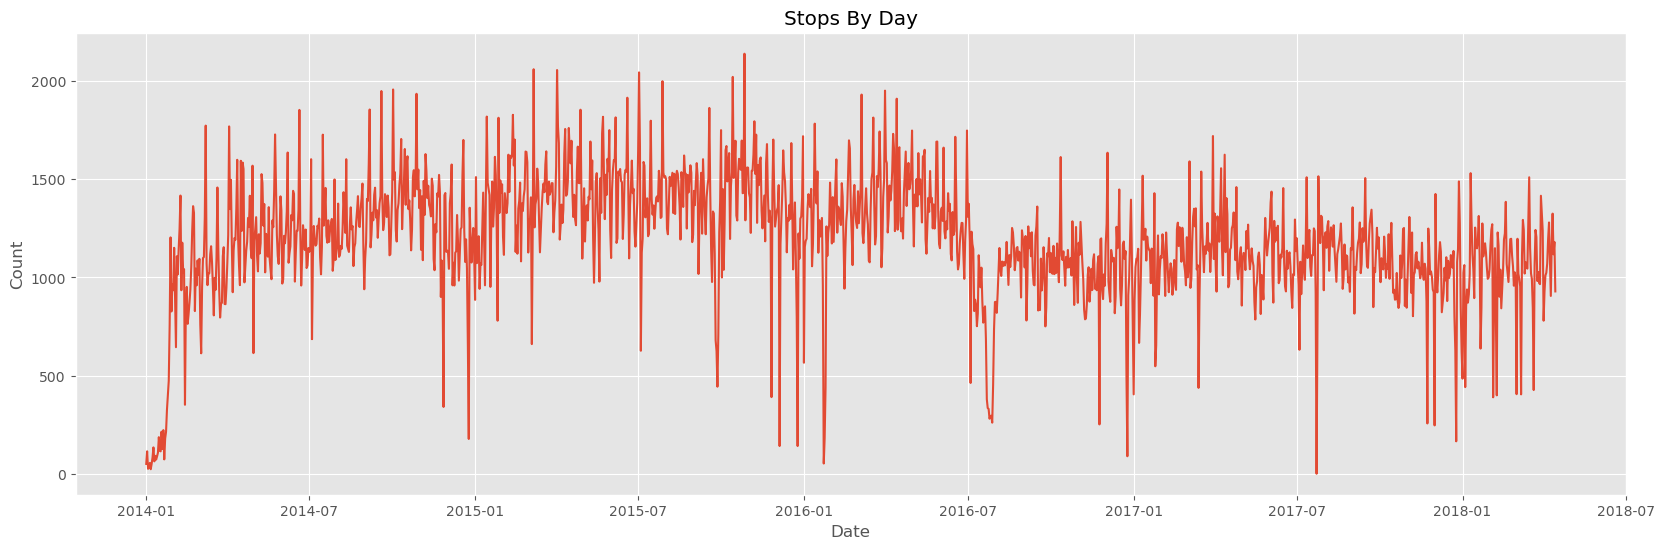

In [24]:
date_data = df.groupby("date").size() # Group by day
sns.lineplot(data = date_data)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Stops By Day")
plt.show()

In [25]:
print(f"Day with the most stops was {date_data.idxmax()} with {date_data.max()} events")

Day with the most stops was 2015-10-27 00:00:00 with 2139 events


In [26]:
print(f"Day with fewest sotps was {date_data.idxmin()} with {date_data.min()} events")

Day with fewest sotps was 2017-07-23 00:00:00 with 1 events


In [27]:
date_data.index.inferred_freq # Data freqency

'D'

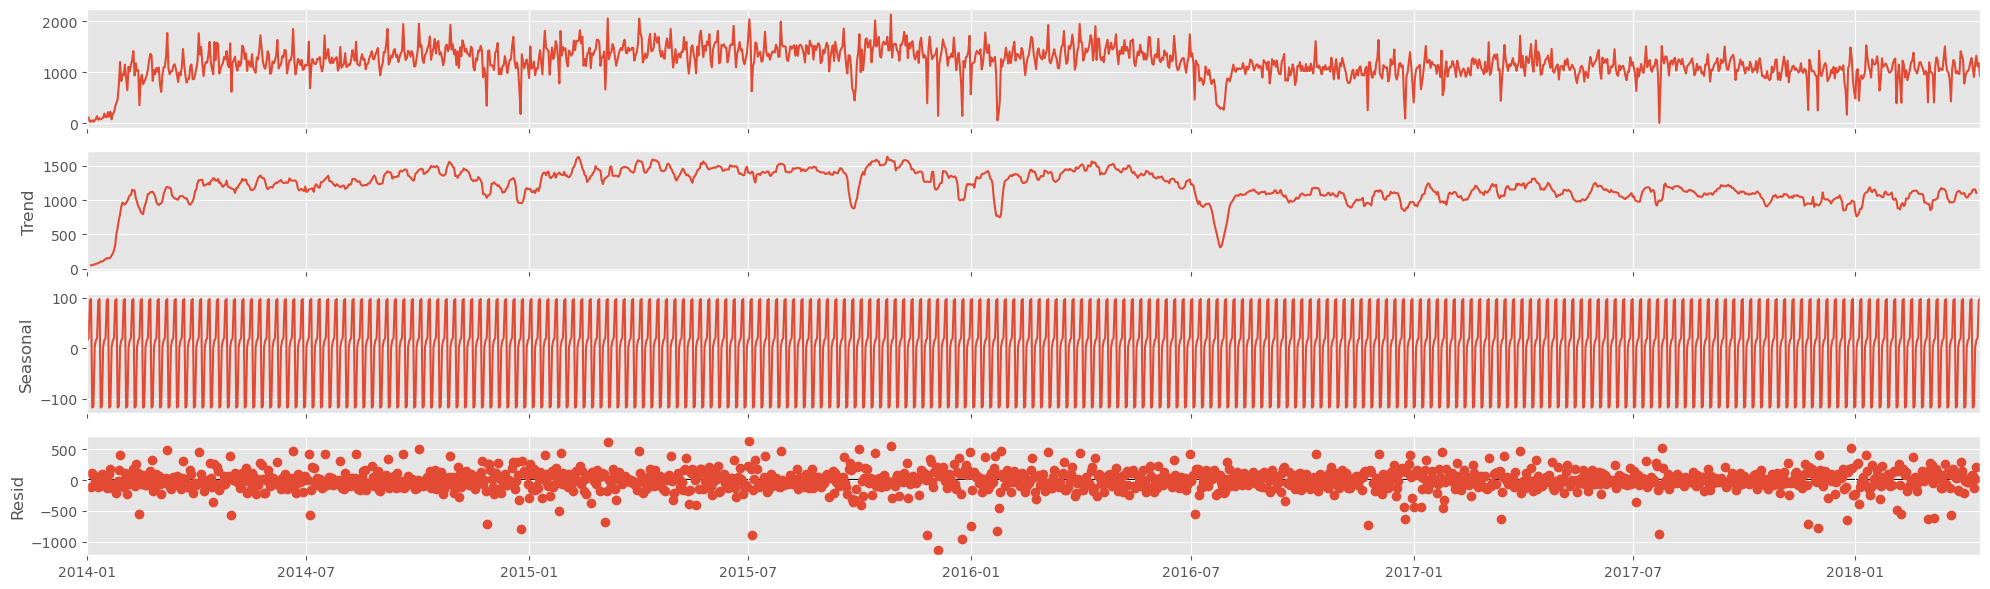

In [28]:
# Seasonal decompose
decompose = seasonal_decompose(date_data, model='additive', period = 7)  
decompose.plot()
plt.tight_layout()
plt.show()

The observed data shows a relatively high and stable daily count until early 2016, after which a noticeable drop occurs and stabilizes at a lower level. The trend component confirms this shift, highlighting a gradual increase in activity through 2014–2015 followed by a sharp decline around early 2016 and a flatter pattern afterward. The seasonal component displays a strong, consistent weekly cycle, suggesting that the data exhibits predictable fluctuations tied to days of the week. This pattern remains stable in shape and amplitude throughout the entire period. Lastly, the residual component shows moderate dispersion around zero, with occasional outliers, indicating that while the decomposition explains much of the variability, there are still some irregular, potentially exceptional events not captured by the model. Overall, this decomposition suggests strong weekly seasonality, a meaningful long-term trend shift, and relatively well-behaved residuals, making it a valuable basis for further forecasting or anomaly detection.

The decrease in vehicle stops in Philadelphia in 2016 was due to a combination of factors, including the implementation of police reforms ([stop and frisk](https://www.drkattorneys.com/blog/stop-and-frisk-laws/)), increased oversight of stop practices, and a focus on racial equity. These measures reflect a concerted effort by the city to promote fairer and more effective policing practices.

In [30]:
# Create additional date values

df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month_name()
df["Day"] = df["date"].dt.day
df["Day_Week"] = df["date"].dt.day_name()
df[["Year", "Month", "Day", "Day_Week"]].head()

,Year,Month,Day,Day_Week
0,2014,January,1,Wednesday
1,2014,January,1,Wednesday
2,2014,January,1,Wednesday
3,2014,January,1,Wednesday
4,2014,January,1,Wednesday


#### 2.1 Year

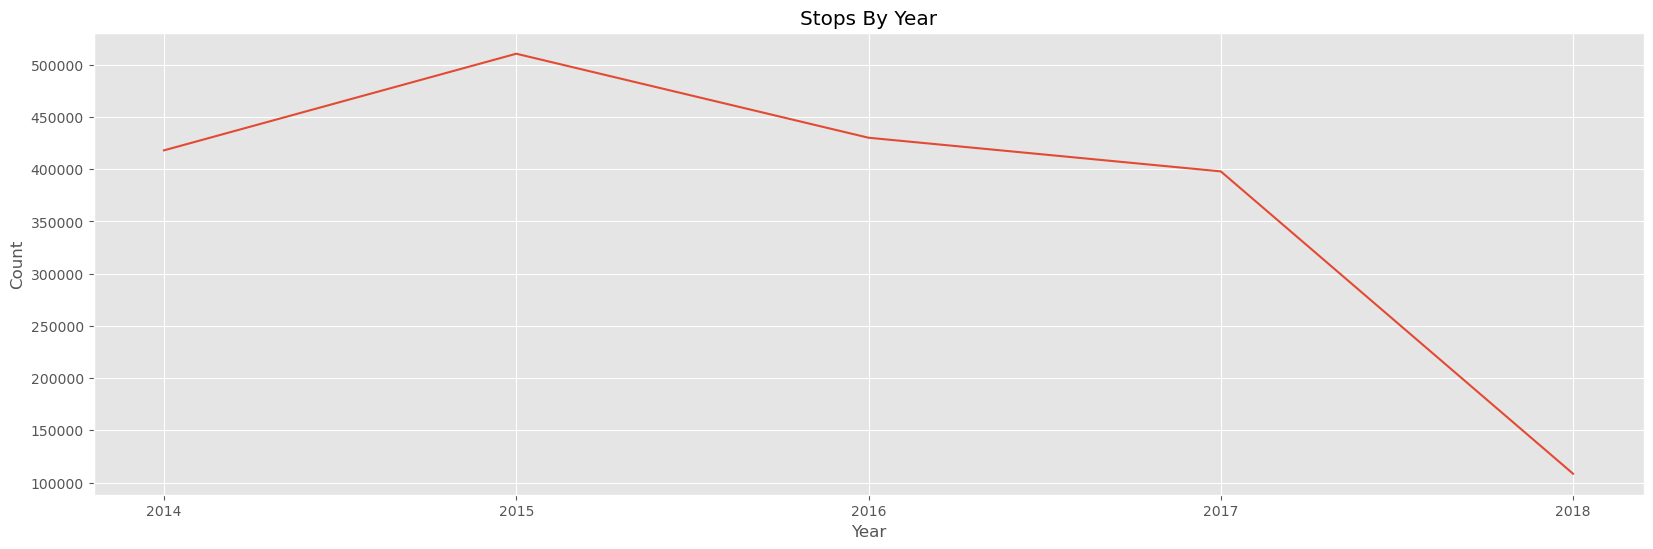

In [32]:
year_data = df.groupby(df["Year"]).size().reset_index(name = "Count")
sns.lineplot(data = year_data, x = "Year", y = "Count")
plt.xticks(year_data["Year"])
plt.title("Stops By Year")
plt.show()

In [33]:
year_data

,Year,Count
0,2014,418031
1,2015,510534
2,2016,430114
3,2017,397908
4,2018,108509


In 2014, 2016 and 2017 around 40,000 stops were made. The highest number of stops was in 2015, with more than 50,000. The lower figure compared to 2018 is due to the fact that data is available up to April 14, 2018.

The decrease after 2015, (2016-2017) is related to the modification of *stop and frisk* practices among police forces in order to guarantee racial equity.

#### 2.2 Month

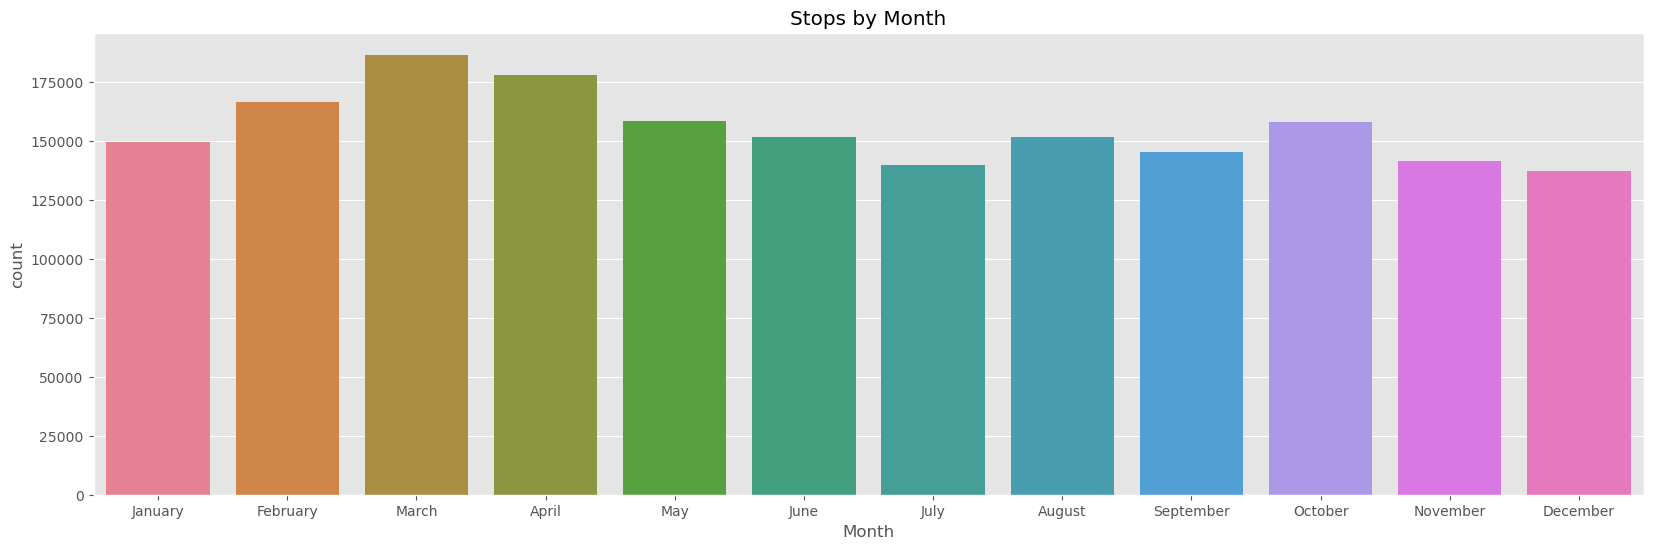

In [36]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

df["Month"] = pd.Categorical(df["Month"], categories = months_order, ordered = True)
sns.countplot(data = df, x = "Month", hue = "Month")
plt.title("Stops by Month")
plt.show()

The bar chart shows that March has the highest number of vehicle stops, followed closely by April and February. This peak in March may be explained by several factors. First, it marks the transition from winter to spring, which often leads to increased traffic as weather conditions improve. Additionally, law enforcement agencies may launch seasonal traffic enforcement campaigns during this time, focusing on issues like speeding or impaired driving. March also coincides with the end of the first fiscal quarter, which may prompt intensified operations for reporting or budgetary reasons. Furthermore, the return to school or university after winter breaks may increase daily vehicle flow. This idea is further supported by the noticeable decline in vehicle stops starting in November, when winter begins and road activity typically decreases due to colder weather and holiday-related slowdowns.

#### 2.3 Day

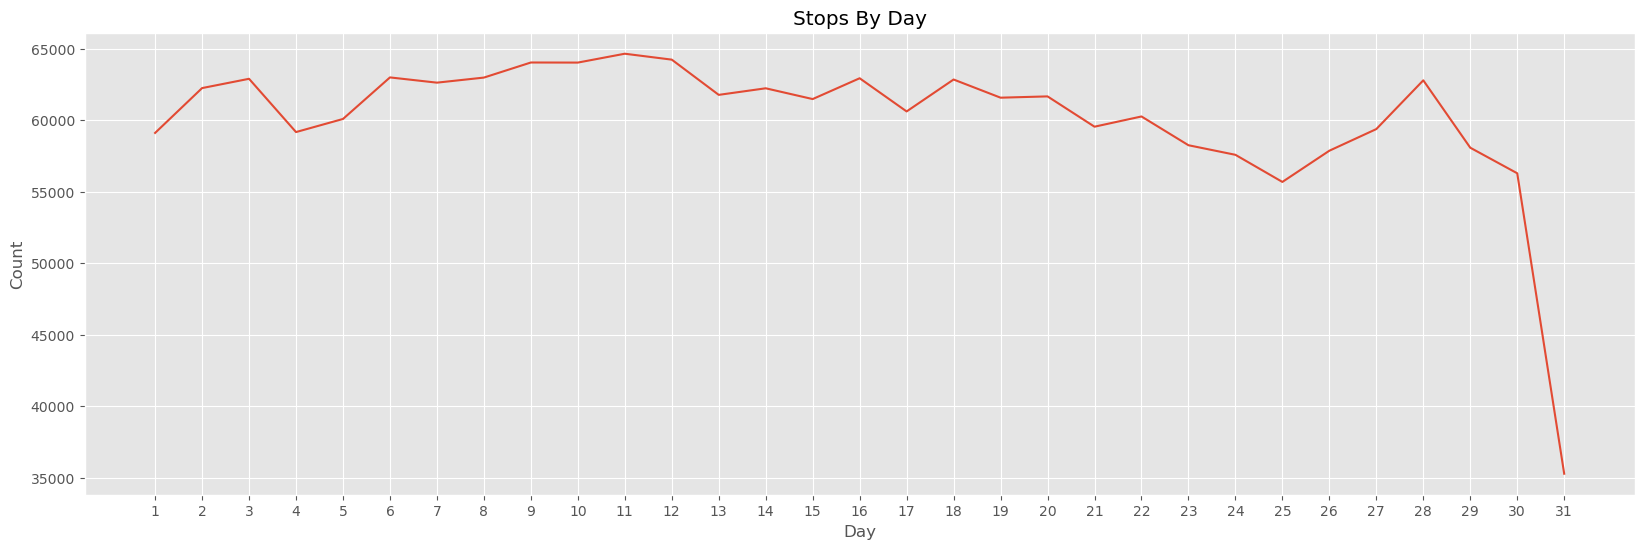

In [39]:
day_data = df.groupby("Day").size().reset_index(name = "Count")
sns.lineplot(data = day_data, x = "Day", y = "Count")
plt.xticks(day_data["Day"])
plt.title("Stops By Day")
plt.show()

There are few data on day 31 because not all months have 31 days. 

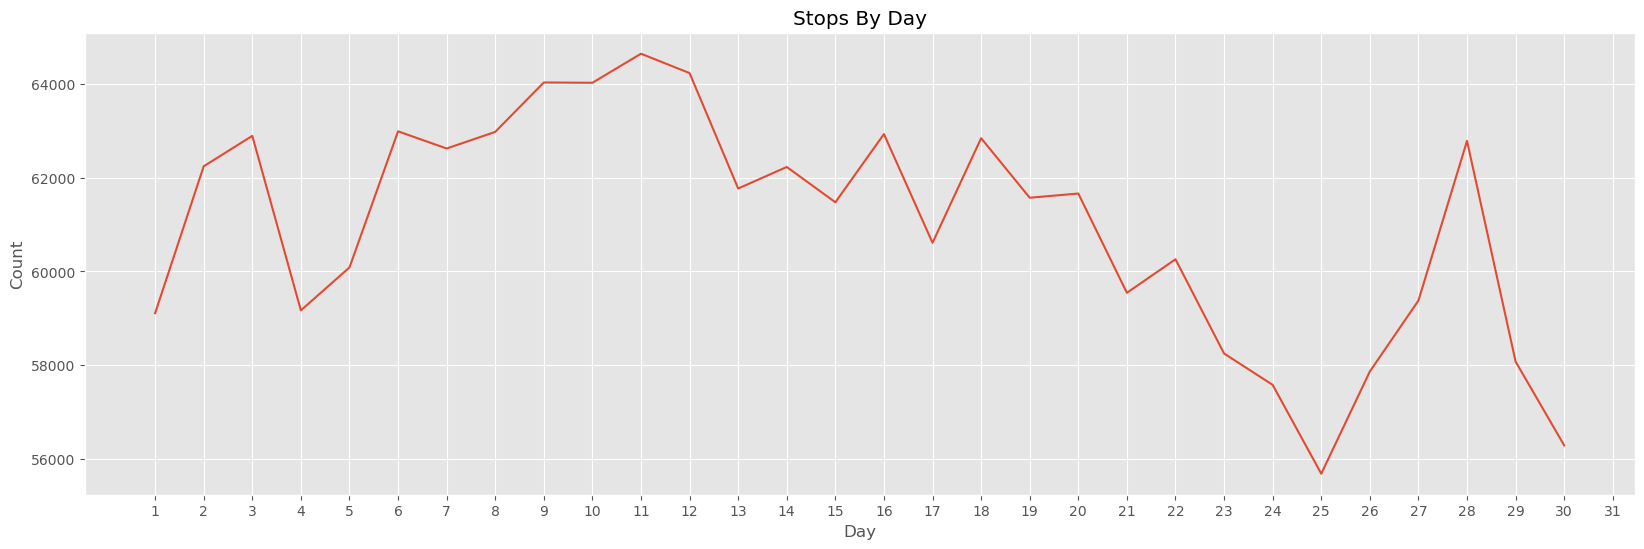

In [41]:
# Do not take into account day 31 info
sns.lineplot(data = day_data[day_data["Day"] < 31], x = "Day", y = "Count")
plt.xticks(day_data["Day"])
plt.title("Stops By Day")
plt.show()

The first half of the month, particularly the first 12 days, shows consistently high numbers of stops, peaking around the 11th. After that, there's a gradual decline in stops, reaching a significant low around the 25th. Interestingly, a brief surge occurs between the 27th and 29th before dropping again at the end of the month. This pattern may suggest increased enforcement activity at the beginning of the month, possibly linked to administrative cycles, resource availability, or policy targets, followed by a slowdown, and then a final push toward the month's end.

#### 2.4 Day of the Week

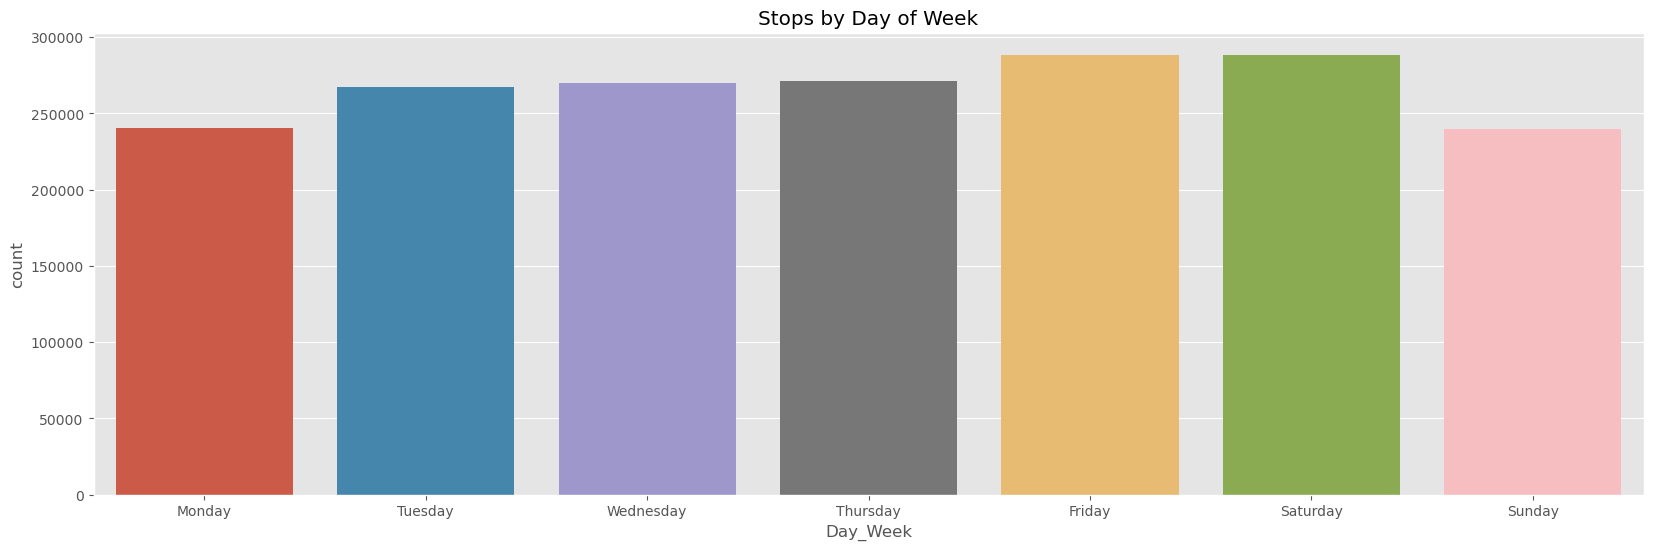

In [44]:
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Day_Week"] = pd.Categorical(df["Day_Week"], categories = days_order, ordered = True)
sns.countplot(data = df, x = "Day_Week", hue = "Day_Week")
plt.title("Stops by Day of Week")
plt.show()

Vehicle stops gradually increase from Monday through Saturday, with Friday and Saturday showing the highest counts. This suggests intensified traffic monitoring and enforcement toward the end of the workweek and into the weekend, possibly due to higher traffic volumes or a greater focus on weekend-related infractions. In contrast, Monday and Sunday show the lowest number of stops, which may reflect lighter traffic, fewer enforcement operations, or reduced mobility during those days. Overall, the chart highlights a weekly cycle in vehicle stops that aligns with expected fluctuations in daily traffic behavior.

### **3. time**

In [47]:
df["time"]

0          01:14:00
1          01:57:00
2          03:30:00
3          03:40:00
4          08:30:00
             ...   
1865091    21:36:00
1865092    22:01:00
1865093    22:48:00
1865094    22:48:00
1865095    23:10:00
Name: time, Length: 1865096, dtype: object

In [48]:
df["time"] = pd.to_datetime(df["time"], format = '%H:%M:%S').dt.time
df["time"]

0          01:14:00
1          01:57:00
2          03:30:00
3          03:40:00
4          08:30:00
             ...   
1865091    21:36:00
1865092    22:01:00
1865093    22:48:00
1865094    22:48:00
1865095    23:10:00
Name: time, Length: 1865096, dtype: object

In [49]:
df["Hour"] = df["time"].apply(lambda x: x.hour)
df["Hour"]

0           1
1           1
2           3
3           3
4           8
           ..
1865091    21
1865092    22
1865093    22
1865094    22
1865095    23
Name: Hour, Length: 1865096, dtype: int64

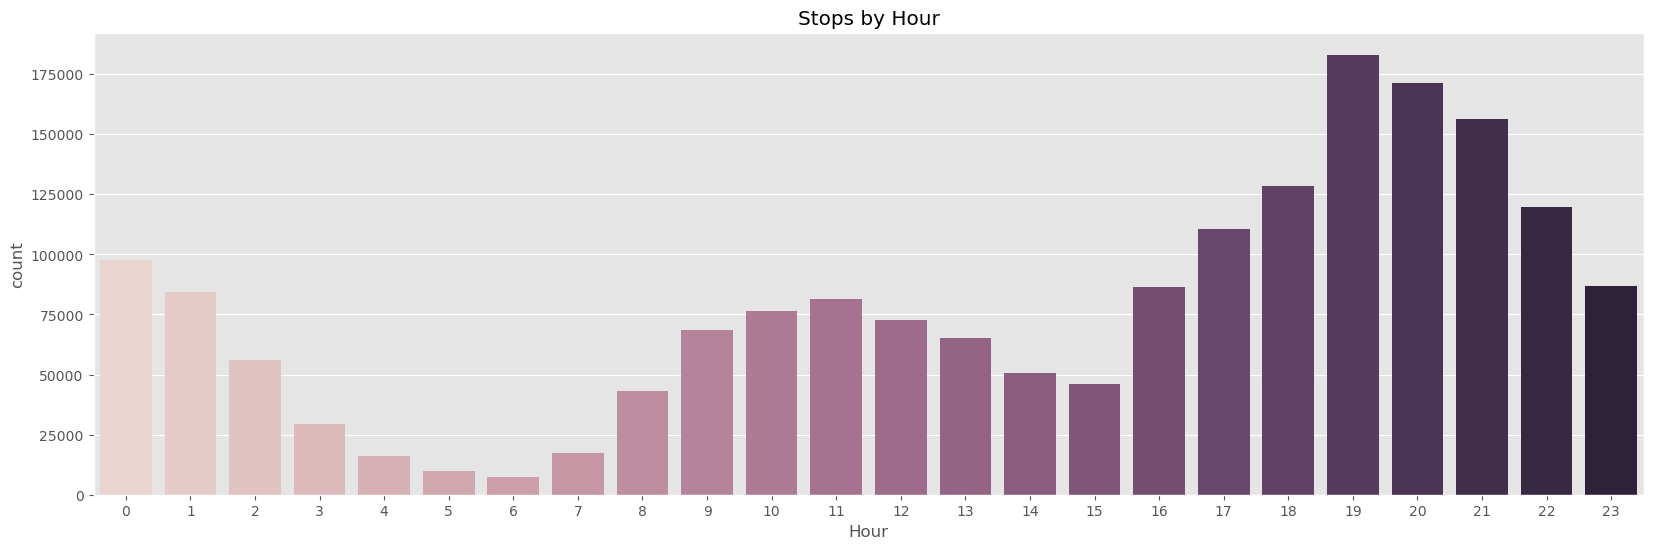

In [50]:
sns.countplot(data = df, x = "Hour", hue = "Hour")
plt.legend().remove()
plt.title("Stops by Hour")
plt.show()

The early morning hours, particularly between 0:00 and 2:00, show relatively high stop counts, possibly linked to nighttime patrols or late-night traffic enforcement. Activity then drops sharply between 3:00 and 7:00, likely reflecting reduced traffic and a potential change of shift for police forces around 6:00, which may temporarily lower enforcement presence. From 8:00 onward, the number of stops begins to rise, with moderate activity observed during late morning and a slight dip around 12:00–14:00, which could correspond to lunch hours, both for drivers and officers. The most significant surge begins at 16:00 and peaks around 19:00, aligning with evening rush hour and increased road activity. After 20:00, the counts gradually decline but remain relatively high through 23:00. Overall, the chart suggests that enforcement patterns are strongly influenced by daily traffic rhythms, operational schedules, and practical considerations like meal breaks and shift transitions.

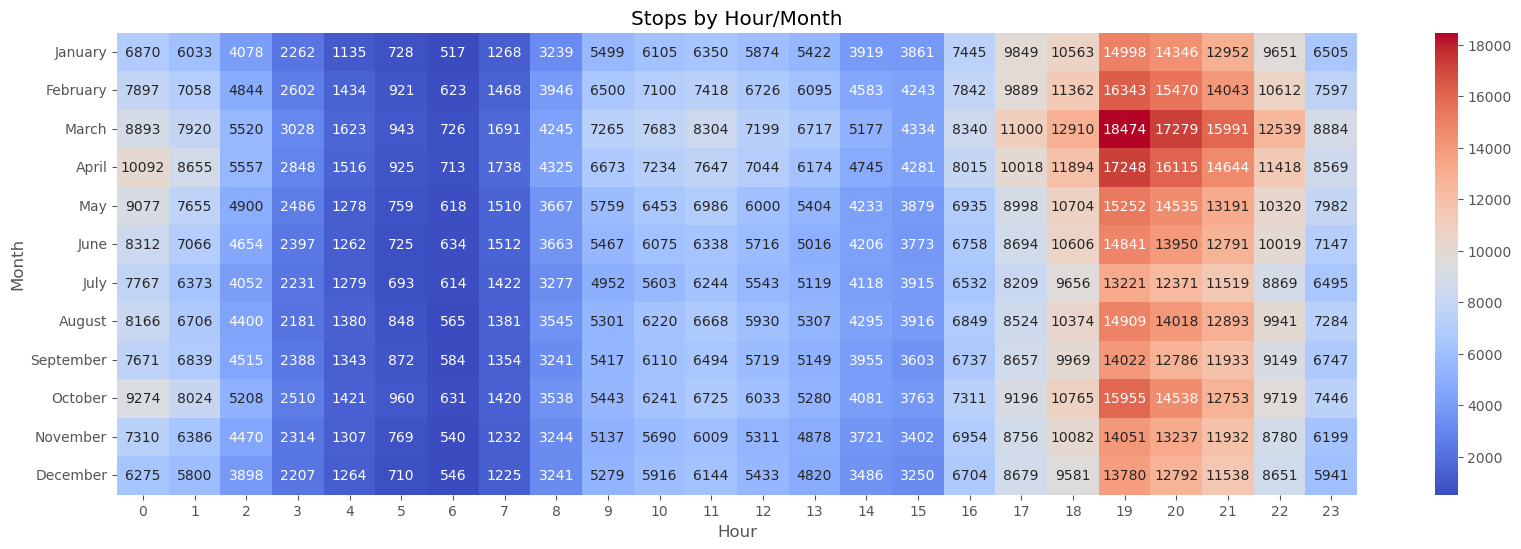

In [52]:
pivot_month_hour = df.pivot_table(index = "Month",
                                  columns = "Hour",
                                  aggfunc = "size", 
                                  observed = False)

sns.heatmap(pivot_month_hour, cmap = "coolwarm", annot = True, fmt='g')
plt.title("Stops by Hour/Month")
plt.show()


Consistent with earlier analyses, the highest concentration of stops occurs between 17:00 and 21:00, reflecting peak traffic periods, especially during evening commutes. March, April, and May stand out with the most intense activity during these hours, supporting the idea that vehicle stops increase in spring due to improved weather, higher traffic flow, and possibly seasonal enforcement efforts. Conversely, the lowest levels of activity are observed between 3:00 and 6:00 across all months, likely due to reduced mobility and early morning police shift transitions. December, January, and February show relatively lower totals overall, which may be attributed to winter conditions that limit driving and reduce the frequency of stops. 

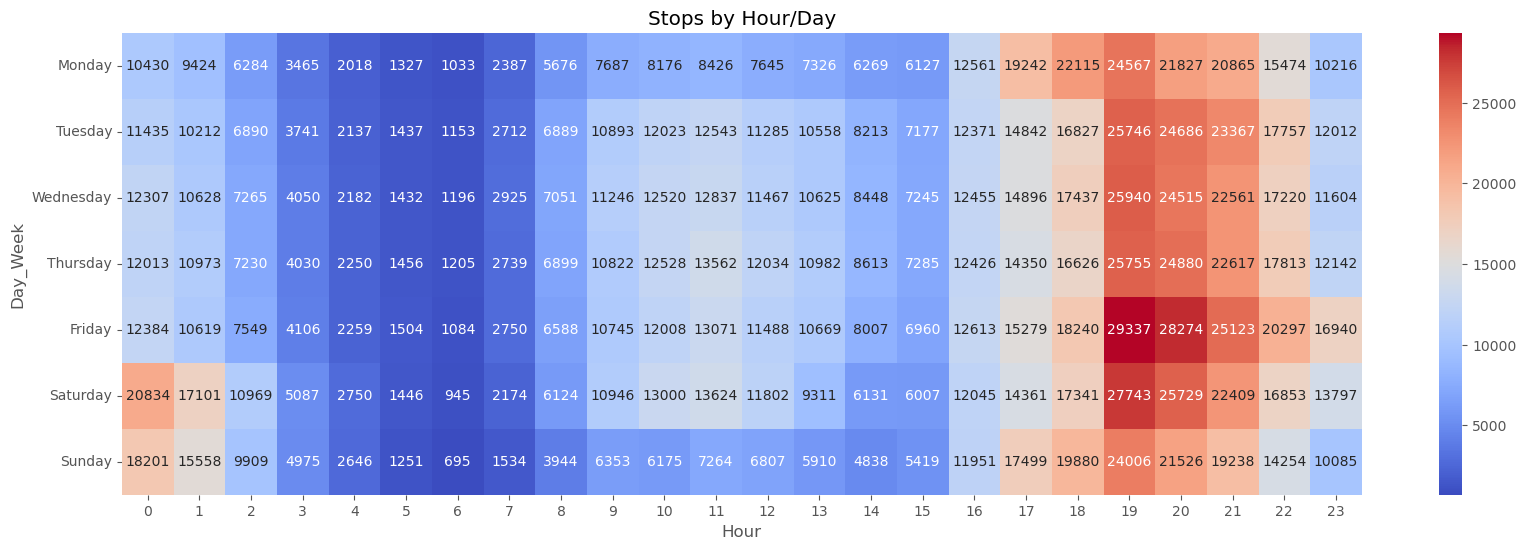

In [54]:
pivot_day_hour = df.pivot_table(index = "Day_Week",
                                  columns = "Hour",
                                  aggfunc = "size", 
                                  observed = False)

sns.heatmap(pivot_day_hour, cmap = "coolwarm", annot = True, fmt='g')
plt.title("Stops by Hour/Day")
plt.show()

As seen in previous analyses, the highest volume of stops occurs between 17:00 and 21:00 across all days, with Friday and Saturday showing the most intense activity—peaking notably around 19:00 and 20:00. This likely reflects increased traffic volume and police presence during weekend nights, possibly targeting leisure-related mobility and impaired driving. In contrast, the early morning hours between 3:00 and 6:00 consistently register the lowest stop counts, aligning with expected reductions in traffic and potential police shift changes. Weekdays exhibit a smoother progression of stops from morning through evening, while weekends show a broader spread of higher activity throughout the day, especially starting from midday. Sunday maintains elevated stop levels until late evening, though slightly lower than Saturday.

### **4. Location**

In [57]:
location_date = pd.DataFrame(df["location"].dropna())
location_date

,location
2,3400 BLOCK SPRUCE ST
3,3400 BLOCK SPRUCE ST
4,N 56TH ST / UPLAND WAY
5,CHESTNUT ST / S SCHUYLKILL AV W
6,N 52ND ST / GAINOR RD
...,...
1865091,S 59TH ST / ELMWOOD AV
1865092,2600 BLOCK JUDSON ST
1865093,500 BLOCK E OLNEY AV
1865094,500 BLOCK E OLNEY AV


In [58]:
location_date.value_counts().head(10)

location                   
3200 BLOCK KENSINGTON AV       3610
3100 BLOCK KENSINGTON AV       3576
800 BLOCK E ALLEGHENY AV       3471
3000 BLOCK KENSINGTON AV       2925
5900 BLOCK MARKET ST           2847
100 BLOCK W LEHIGH AV          2696
100 BLOCK E TUSCULUM ST        2619
4600 BLOCK E ROOSEVELT BLVD    2588
100 BLOCK W CAMBRIA ST         2356
600 BLOCK E INDIANA AV         2352
Name: count, dtype: int64

In [59]:
location_date.value_counts().tail(10)

location                
N 1500 BUTLER ST            1
55TH & RACE ST              1
N 14TH ST / WINDRIM AV      1
N 14TH ST / W CAYUGA ST     1
N 13TH ST/POPLAR            1
N 13TH ST/ W RUSCOMB ST     1
55TH & ARCH ST              1
55TH & CATHERINE ST         1
55TH & GIRARD AVE           1
s BROAD ST / PATTISON AV    1
Name: count, dtype: int64

In [60]:
location_date['location'] = location_date['location'].str.upper()

In [61]:
def name_road(location):
    

    location = location.split('/')[-1]

    
    location = re.sub(r'\b\d+\b', '', location)           # elimina números
    location = re.sub(r'\b(BLOCK|N|S|E|W)\b', '', location)  # elimina palabras clave comunes
    location = re.sub(r'\s+', ' ', location)           # normaliza espacios
    return location.strip()

# Aplicar la función
location_date['clean_street'] = location_date['location'].apply(name_road)

<Axes: xlabel='clean_street'>

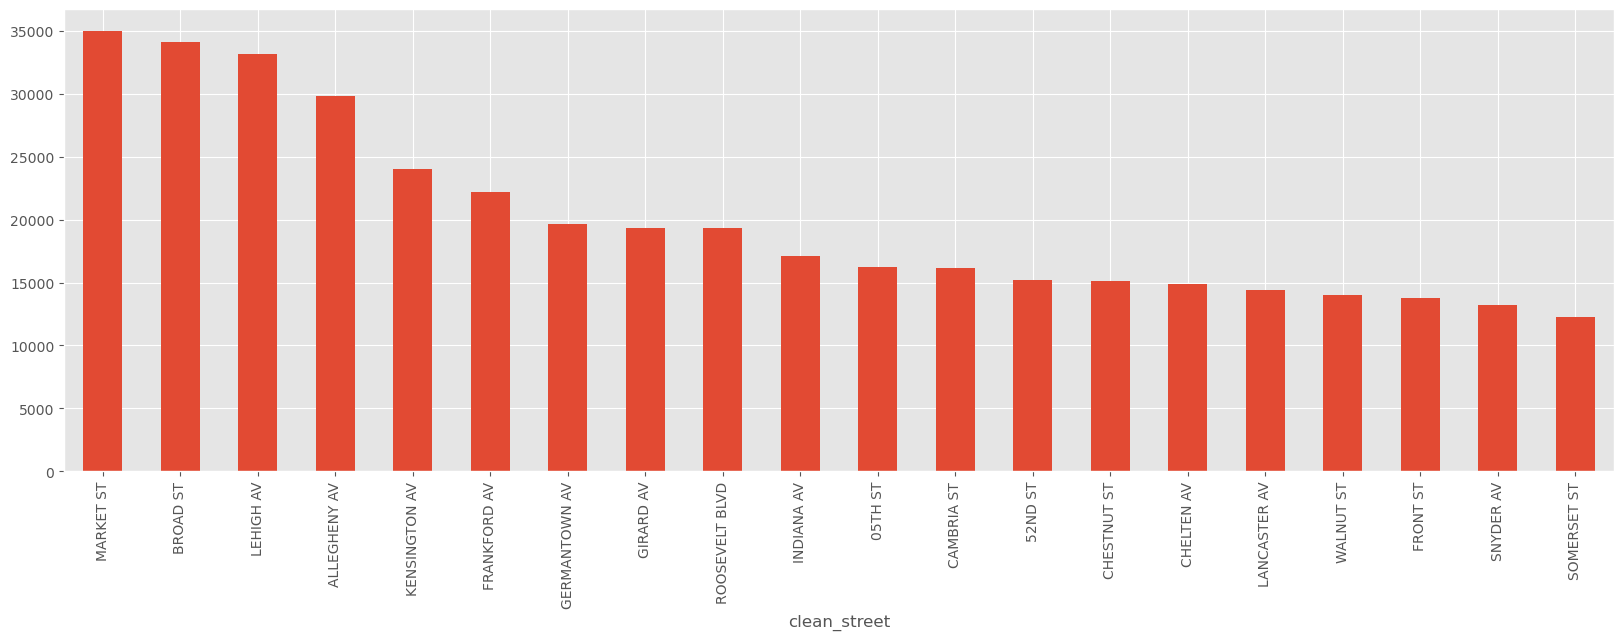

In [62]:
location_date["clean_street"].value_counts().head(20).plot(kind = "bar")

In [63]:
top_stops_streets = pd.DataFrame(location_date["clean_street"].value_counts().head(10).reset_index(name = "count"))
top_stops_streets

,clean_street,count
0,MARKET ST,34972
1,BROAD ST,34094
2,LEHIGH AV,33196
3,ALLEGHENY AV,29815
4,KENSINGTON AV,24004
5,FRANKFORD AV,22158
6,GERMANTOWN AV,19618
7,GIRARD AV,19344
8,ROOSEVELT BLVD,19296
9,INDIANA AV,17077


In [64]:
top_stops_streets[["name", "type"]] = top_stops_streets["clean_street"].str.split(" ", expand = True)
top_stops_streets["type"] = top_stops_streets["type"].str.replace("AV", "AVE")
top_stops_streets

,clean_street,count,name,type
0,MARKET ST,34972,MARKET,ST
1,BROAD ST,34094,BROAD,ST
2,LEHIGH AV,33196,LEHIGH,AVE
3,ALLEGHENY AV,29815,ALLEGHENY,AVE
4,KENSINGTON AV,24004,KENSINGTON,AVE
5,FRANKFORD AV,22158,FRANKFORD,AVE
6,GERMANTOWN AV,19618,GERMANTOWN,AVE
7,GIRARD AV,19344,GIRARD,AVE
8,ROOSEVELT BLVD,19296,ROOSEVELT,BLVD
9,INDIANA AV,17077,INDIANA,AVE


In [115]:
with open("streets.geojson") as f:
    data_streets = geojson.load(f)

map = folium.Map(location=[39.96, -75.15], zoom_start=12, tiles='cartodbpositron')

max_val = max(top_stops_streets["count"])
min_val = min(top_stops_streets["count"])
colormap = linear.YlOrRd_05.to_step(10)
# colormap.colors = colormap.colors[::-1]
colormap = colormap.scale(min_val, max_val)
colormap.caption = 'Roads with more stops'

features_filtered = []

for feature in data_streets['features']:
    name = feature['properties'].get('ST_NAME', '').upper()
    type = feature['properties'].get('ST_TYPE', '').upper()
    
    for i in list(zip(top_stops_streets["name"], top_stops_streets["type"])):
        if (name == i[0]) and (type == i[1]):
            feature['properties']['value'] = int(top_stops_streets.loc[top_stops_streets["name"] == name, "count"].values[0])
            features_filtered.append(feature)

# Crear una nueva FeatureCollection con solo esas calles
geojson_filtered = {
    "type": "FeatureCollection",
    "features": features_filtered
}

# Función para estilizar según valor
def style(feature):
    value = feature['properties']['value']
    return {
        'color': colormap(value),
        'weight': 4,
        'opacity': 0.8
    }

# Agregar al mapa
folium.GeoJson(
    geojson_filtered,
    style_function = style,
    tooltip = folium.GeoJsonTooltip(fields=["ST_NAME", "value"], aliases=["Road:", "Value:"])
).add_to(map)

# Agregar la barra de colores
colormap.add_to(map)

# Mostrar el mapa (si estás en Jupyter Notebook)
map



In [119]:
map.save("top_roads.html")

  de multas

### lat lng
- posicionar la información sobre un mapa

### District
- Diagrama de barras

### Service Area
- Diagrama de Barras